# PLSDA Cancer Classification on GBM Cell Lines

In [109]:
import csv
import time

import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
import scipy.io as sio
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import r2_score

LOG_FLAG = False  # Flag to print debugging/log text

# Parsing Data
After performing preprocessing on our images, the input data for this program will be a '.csv' file. The following code parses the data in that file and stores it into two arrays. X will be the array that contains the pixel color values for all of the pixels in all 100 of our images. Y will be the array which lists the label (0) mes or (1) pro for each of the cell images. 

In [110]:
csv_filename = '/Users/Ryan/Dropbox/Sharing/project data/128_data.csv'

IMAGE_DIM = 128   # Images cut into sizes of IMAGE_DIM x IMAGE_DIM
data = []    # Data matrix to hold csv read data

# Open CSV, read row by row, parsing into data matrix
with open(csv_filename, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        data.append(row[1:])  
data = np.array(data)

# Separate data matrix into X inputs and Y labels. Y labels are indicated 
# by the last column
X = data[:, 0:-1]
Y = data[:, -1]
X = X.astype(int)
Y = Y.astype(int)

## Verify and Normalize Parsed Data
Read data from data matrix, ensure that the labels are what we expect, and if so, zscore

In [111]:
def verify_y_vector(y):
    '''Ensures that y vector consists of only labels 0 and 1'''
    for label in y:
        if label != 0 and label != 1:
            return False
    return True

In [112]:
# Test integrity of parsed Y vector
assert(verify_y_vector(Y) == True)

# Normalize data
x_zscore = scipy.stats.mstats.zscore(X, axis=0)

y_zscore = scipy.stats.zscore(Y)
Y_mean = np.mean(Y)
Y_std = np.std(Y)

In [113]:
# Print data shape
print("Inputs matrix size: {}".format(X.shape))
print("Outputs matrix size: {}".format(Y.shape))

Inputs matrix size: (182, 16383)
Outputs matrix size: (182,)


# Preprocessing

We characterize some properties of our data. Namely, we first compute R2X and R2Y for increasing number of components. We indicate that a 90% threshold of captured Y-variance is the determining factor in the number of components used to perform our PLS Regression. This process is illustrated below, accompanied by the scores plot to visualize the resulting relationships.

#### Calculation of R2X and R2Y
This will be used to determin how many primary components to use

In [114]:
def R2 (model, observed):
    diff = np.squeeze(np.subtract(model, observed))
    sum_sq_err = np.sum(np.square(diff))
    sq_obs = np.sum(np.square(observed))
    return 1 - (sum_sq_err/sq_obs)

def compute_r2x (scores, loadings, observed):
    loadings_transpose = np.ndarray.transpose(loadings)
    model = np.squeeze(np.dot(scores, loadings_transpose))
    return R2(model, observed)

91.3128947846 % of variation for y accounted for using 7 PCs.


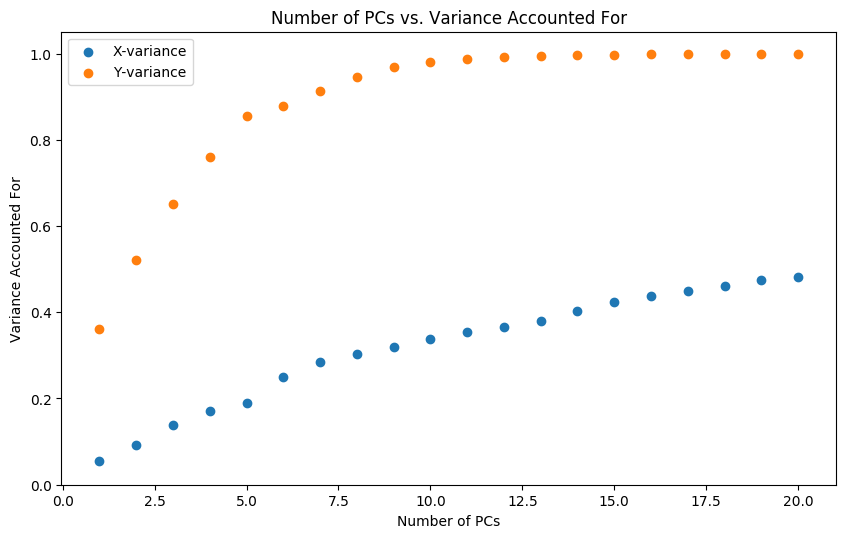

In [115]:
min_num_pcs = 0     # Stores the min num PCs required 
                    # to capture 90% of Y-variance
max_pcs = 20    # Upper bound on PCs
    
R2X_range = []
R2Y_range = []

reach_90_x = False  # Flag set in the for loop below if we reach 
                    # 90% X variance captured
reach_90_y = False  # Flag set in the for loop below if we reach 
                    # 90% Y variance captured

# Compute captured variance for the PC range for both X and Y
for i in range(max_pcs):
    pls = PLSRegression(n_components=(i+1))
    pls.fit(x_zscore,y_zscore)
    
    # Compute R2X from scores and loadings
    R2X = compute_r2x(pls.x_scores_, pls.x_loadings_, x_zscore)
    R2X_range.append(R2X)
    if (R2X > 0.9) and not reach_90_x:
        print((100 * R2X), "% of variation for x accounted for using",(i+1), "PCs.")
        reach_90_x = True
    
    # Compute R2Y
    Y_model = np.squeeze(pls.predict(x_zscore))
    R2Y = R2(Y_model, y_zscore)
    R2Y_range.append(R2Y)
    if (R2Y > 0.9) and not reach_90_y:
        print((100 * R2Y), "% of variation for y accounted for using", (i+1), "PCs.")
        min_num_pcs = i+1   # Set Min num PCs here for use later 
        reach_90_y = True


# Plot results
plt.figure(figsize =(10, 6), dpi=100)
plt.title("Number of PCs vs. Variance Accounted For")
plt.xlabel("Number of PCs")
plt.ylabel("Variance Accounted For")
plt.scatter(np.arange(1,max_pcs+1), R2X_range, label="X-variance")
plt.scatter(np.arange(1,max_pcs+1), R2Y_range, label="Y-variance")
plt.legend()
plt.show()


Verifying X_scores shape: (182, 7)


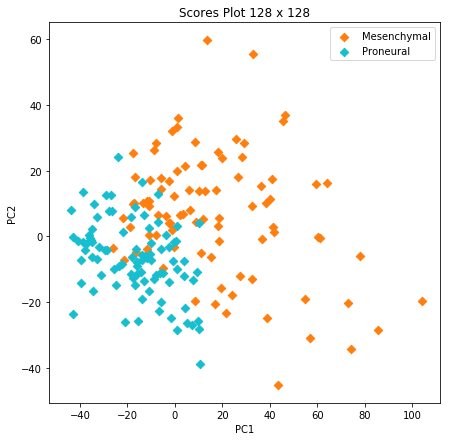

In [117]:
# Based on the PCs we found to capture 90% variance in Y, 
# we use that to continue our analysis. Here we construct 
# a scores plot
plsda = PLSRegression(n_components = min_num_pcs)
plsda.fit(x_zscore,y_zscore)
print("Verifying X_scores shape: {}".format(plsda.x_scores_.shape))

# Extract PC1 and PC2
scores_PC1 = plsda.x_scores_[:, 0]
scores_PC2 = plsda.x_scores_[:, 1]

# Since we know the number of observations are the same for mesenchymal 
# and pronerual the number of observations for each is half of the total 
num_observations_for_class = X.shape[0] // 2

# Plot scores, separating into Mes and Pro classes based on label. 
# Because we know the order in which we structured the CSV, we know 
# the first half is mesenchymal and the second is proneural
plt.figure(figsize =(7,7))
plt.title("Scores Plot {} x {}".format(IMAGE_DIM, IMAGE_DIM))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(scores_PC1[0:num_observations_for_class - 1], 
            scores_PC2[0:num_observations_for_class - 1], 
            c='tab:orange',marker='D', label="Mesenchymal")
plt.scatter(scores_PC1[num_observations_for_class:], 
            scores_PC2[num_observations_for_class:], 
            c='tab:cyan',marker='D', label="Proneural")
plt.legend()
plt.show()

# Assessing PLSDA Prediction Performance

After doing some research online we discovered a method for implementing PLSDA via PLSR. We will build a model using PLSR, where our y_observed is an array of 0s (mesenchymal) or 1s (proneural). PLSR will make predictions which will result in continous values. However, we need our data to be discrete so that we can correctly classify each image into a cell type. Thus, following PLSR, we will need to threshold our y_predicted.

### Leave One Out Cross Validation
Perform LOO cross validation on our model to evaluate the prediction error of our model

### Separate data and train

In [118]:
num_of_comp = min_num_pcs   # The number of PCs we will use for PLS
loo = LeaveOneOut()

pls = PLSRegression(n_components=(num_of_comp))

Y_pred = [] # Stores predictions on the test set based on the 
            # trained model 
Y_test = [] # Stores the true labels. This list is in the same 
            # order as Y_pred so we know the order in which we
            # should compare

# Partition into training and testing sets, taking care to normalize 
# only after separating the data to avoid leakage
for train_index, test_index in loo.split(X, Y):
    # Normalize X data
    pls.fit_transform(X[train_index], Y[train_index])
    pls.transform(X[test_index])
    
    # Predict
    new_y_pred = pls.predict(X[test_index])
    
    # Store predictions and test order
    Y_pred.append(np.squeeze(new_y_pred))
    Y_test.append((Y[test_index]))

### Apply thresholds and build ROC curve

In [119]:
def classify_and_eval_preds(thresh, num_inputs, Y_raw_preds):
    '''Classify predictions based on the threshold'''
    Y_class_preds = []
    for i in range(num_inputs):
        if Y_raw_preds[i] >= thresh:
            Y_class_preds.append(1)
        else:
            Y_class_preds.append(0)
    return np.squeeze(np.array(Y_class_preds))

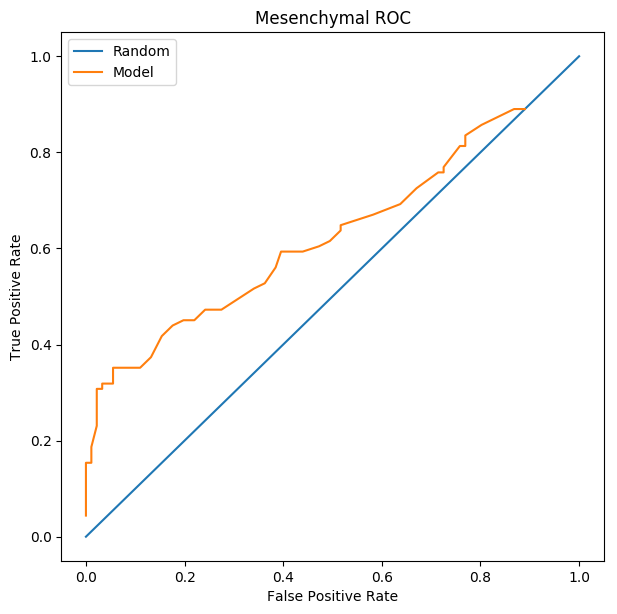

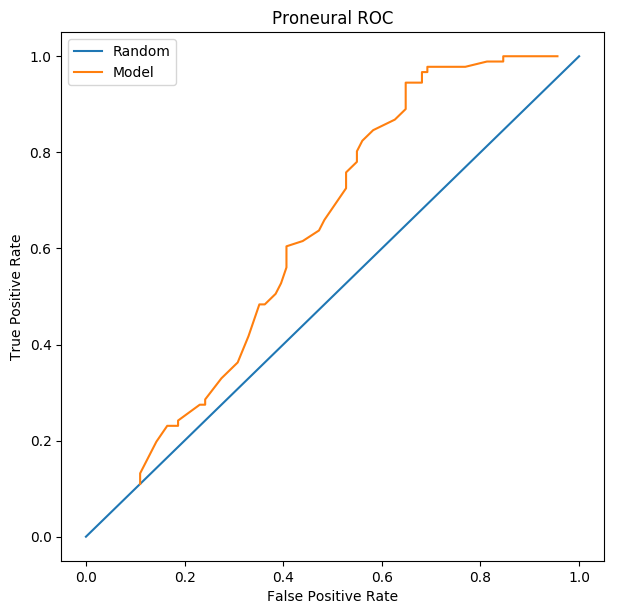

In [120]:
# Threshold our results to classify our data into two categories: 
# (0) mes and (1) pro. Then evaluate the prediction error for our 
# model. We will do this for a range of threshold values from -1 to 1
# and plot the resulting ROC curve
num_observations = X.shape[0] 
num_mes_labels = num_pro_labels = num_observations // 2 # We know that 
                                                        # there are equal 
                                                        # inputs of 
                                                        # mesenchymal and 
                                                        # proneural
thresh_ranges = np.linspace(-1, 1, 100) # Apply a threshold range from -1 to 
                                        # 1 because that is the range for the 
                                        # zscored y labels
mes_tpr_thresh_range = []   # Mesenchymal true positive rates  
mes_fpr_thresh_range = []   # Mesenchymal false positive rates
pro_tpr_thresh_range = []   # Proneural true positive rates
pro_fpr_thresh_range = []   # Proneural false positive rates
                            
for t in thresh_ranges:
    Y_class_pred = []   # Y_pred converted to classes 0 and 1
    Y_class_test = []   # Stores the true labels. This list is in the same 
                        # order as Y_class_pred so we know the order in which 
                        # we should compare
            
    # For each observation, apply threshold and classify
    Y_class_pred = classify_and_eval_preds(t, num_observations, Y_pred)

    # Quantify correct predictions made by our model and compute true/false 
    # positive rates for the ROC curve. 
    mes_true_pos = 0
    mes_false_pos = 0
    pro_false_pos = 0
    pro_true_pos = 0
    
    for i in range(num_observations):
        if (Y_class_pred[i] == Y_test[i]):
            if Y_class_pred[i] == 0:
                mes_true_pos += 1
            else:
                pro_true_pos += 1
        else: 
            if Y_class_pred[i] == 0:
                mes_false_pos += 1
            else:
                pro_false_pos += 1
        
    mes_tpr = mes_true_pos / (num_mes_labels)
    mes_fpr = mes_false_pos / (num_pro_labels)
    pro_tpr = pro_true_pos / (num_pro_labels)
    pro_fpr = pro_false_pos / (num_mes_labels)

    mes_tpr_thresh_range.append(mes_tpr)
    mes_fpr_thresh_range.append(mes_fpr)
    pro_tpr_thresh_range.append(pro_tpr)
    pro_fpr_thresh_range.append(pro_fpr)

    if (LOG_FLAG):
        print("LOO Cross Validation Results [128 CASE]:")
        print("mes cells correctly predicted: ", mes_correct)
        print("mes cells incorrecly predicted: ", mes_false_pos)
        print("pro cells correctly predicted: ", pro_correct)
        print("pro cells incorrectly predicted: ", pro_false_pos)

# Plot data
plt.figure(figsize =(7, 7), dpi=100)
plt.title("Mesenchymal ROC")
plt.plot([0,1], [0,1], label="Random")
plt.plot(mes_fpr_thresh_range, mes_tpr_thresh_range, label="Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

plt.figure(figsize =(7, 7), dpi=100)
plt.title("Proneural ROC")
plt.plot([0,1], [0,1], label="Random")
plt.plot(pro_fpr_thresh_range, pro_tpr_thresh_range, label="Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### K-Fold Crossvalidation

Run 8-fold crossvalidation

In [124]:
# Threshold our results to classify our data into two categories: 
# (0) mes and (1) pro. Then evaluate the prediction error for our 
# model. We will do this for a range of threshold values from -1 to 1
# and plot the resulting ROC curve
num_of_comp = min_num_pcs
num_observations = X.shape[0] 

logo = LeaveOneGroupOut()

# Assign a group to each observation
group_size = 8
groups = []
for i in range(num_observations):
    groups.append(i % group_size)
groups = np.array(groups)

# Convert arrays to numpy arrays to be able to use indexing format
X = np.array(X)
Y = np.array(Y)
X = X.astype(float) # To silence the warnings of performing int with 
                    # float operations

pls_logo = PLSRegression(n_components=(num_of_comp))

Y_pred = [] # Stores predictions on the test set based on the 
            # trained model 
Y_test = [] # Stores the true labels. This list is in the same 
            # order as Y_pred so we know the order in which we
            # should compare

# Split into training and testing data and predict
for train_index, test_index in logo.split(X, groups=groups):
    # Partition 
    X_train = X[train_index]
    Y_train = Y[train_index]
    
    # Normalize X
    scaler = StandardScaler()
    X_train_zs = scaler.fit_transform(X_train)
    X_test_zs = scaler.transform(X[test_index])
    
    # Fit model
    pls_logo.fit(X_train_zs, Y_train)
    
    # Store data
    Y_pred.append(np.squeeze(pls_logo.predict(X_test_zs)))
    Y_test.append(Y[test_index])
    
    # Log
    if (LOG_FLAG):
        print(np.squeeze(np.array(Y_test_pred)))
        print(Y[test_index])

In [125]:
def flatten_logo_output (logo_output):
    '''Flatten data from LOGO crossvalidation in order to easier analyze'''
    flat = []
    for i in range(len(logo_output)):
        for j in range(len(logo_output[i])):
            flat.append(logo_output[i][j])
    return flat


Y_test_flat = np.array(flatten_logo_output(Y_test))
Y_pred_flat = np.array(flatten_logo_output(Y_pred))

if (LOG_FLAG):
    print("Verify shape:")
    print("Y pred flat: ", Y_pred_flat.shape)
    print("Y test flat: ", Y_test_flat.shape)

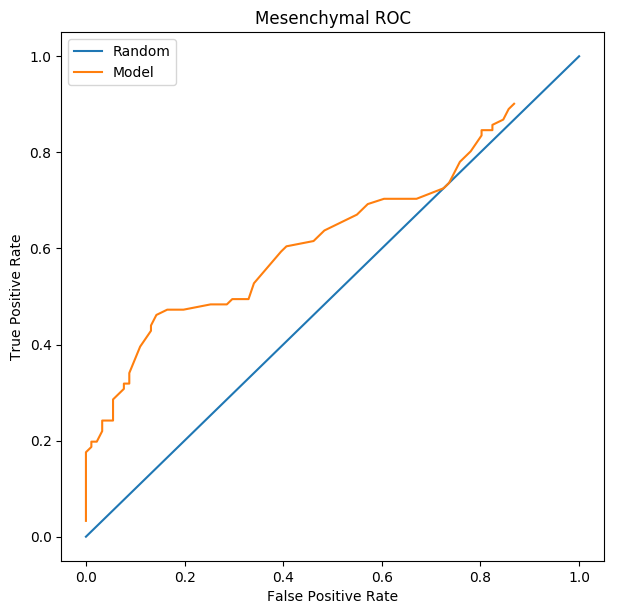

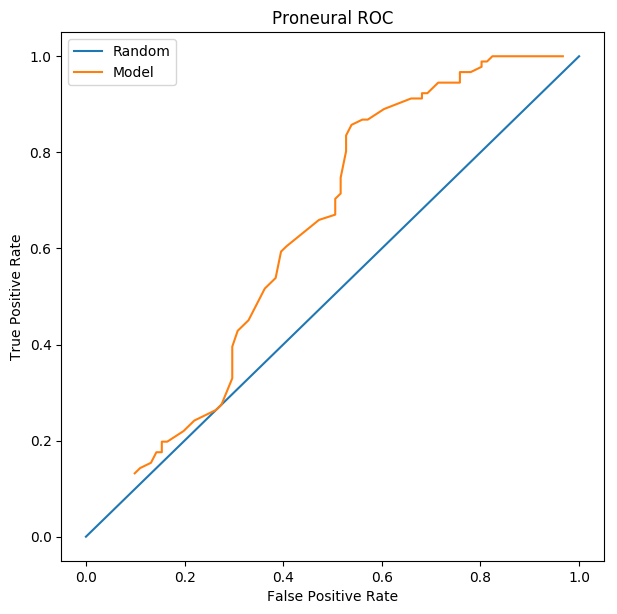

In [126]:
num_mes_labels = num_pro_labels = num_observations // 2 # We know that 
                                                        # there are equal 
                                                        # inputs of 
                                                        # mesenchymal and 
                                                        # proneural
        
thresh_ranges = np.linspace(-1, 1, 100) # Apply a threshold range from -1 to 
                                        # 1 because that is the range for the 
                                        # zscored y labels
mes_tpr_thresh_range = []   # Mesenchymal true positive rates  
mes_fpr_thresh_range = []   # Mesenchymal false positive rates
pro_tpr_thresh_range = []   # Proneural true positive rates
pro_fpr_thresh_range = []   # Proneural false positive rates
                            
for t in thresh_ranges:
    Y_class_pred = []   # Y_pred converted to classes 0 and 1
    
    # For each observation, apply threshold and classify
    Y_class_pred = classify_and_eval_preds(t, num_observations, Y_pred_flat)

    # Quantify correct predictions made by our model and compute true/false 
    # positive rates for the ROC curve. 
    mes_true_pos = 0
    mes_false_pos = 0
    pro_false_pos = 0
    pro_true_pos = 0
    
    for i in range(num_observations):
        if (Y_class_pred[i] == Y_test_flat[i]):
            if Y_class_pred[i] == 0:
                mes_true_pos += 1
            else:
                pro_true_pos += 1
        else: 
            if Y_class_pred[i] == 0:
                mes_false_pos += 1
            else:
                pro_false_pos += 1
        
    mes_tpr = mes_true_pos / (num_mes_labels)
    mes_fpr = mes_false_pos / (num_pro_labels)
    pro_tpr = pro_true_pos / (num_pro_labels)
    pro_fpr = pro_false_pos / (num_mes_labels)

    mes_tpr_thresh_range.append(mes_tpr)
    mes_fpr_thresh_range.append(mes_fpr)
    pro_tpr_thresh_range.append(pro_tpr)
    pro_fpr_thresh_range.append(pro_fpr)
    
    if (LOG_FLAG):
        print("{}-Fold Crossvalidation Results [Thresh: {}]:".format(group_size, t))
        print("mes cells correctly predicted: ", mes_correct)
        print("mes cells incorrecly predicted: ", mes_false_pos)
        print("pro cells correctly predicted: ", pro_correct)
        print("pro cells incorrectly predicted: ", pro_false_pos)
        print("\n\n")

# Plot data
plt.figure(figsize =(7, 7), dpi=100)
plt.title("Mesenchymal ROC")
plt.plot([0,1], [0,1], label="Random")
plt.plot(mes_fpr_thresh_range, mes_tpr_thresh_range, label="Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

plt.figure(figsize =(7, 7), dpi=100)
plt.title("Proneural ROC")
plt.plot([0,1], [0,1], label="Random")
plt.plot(pro_fpr_thresh_range, pro_tpr_thresh_range, label="Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()